# Konvolúciós Neurális Hálózat
## Fashion MNIST Dataset-hez

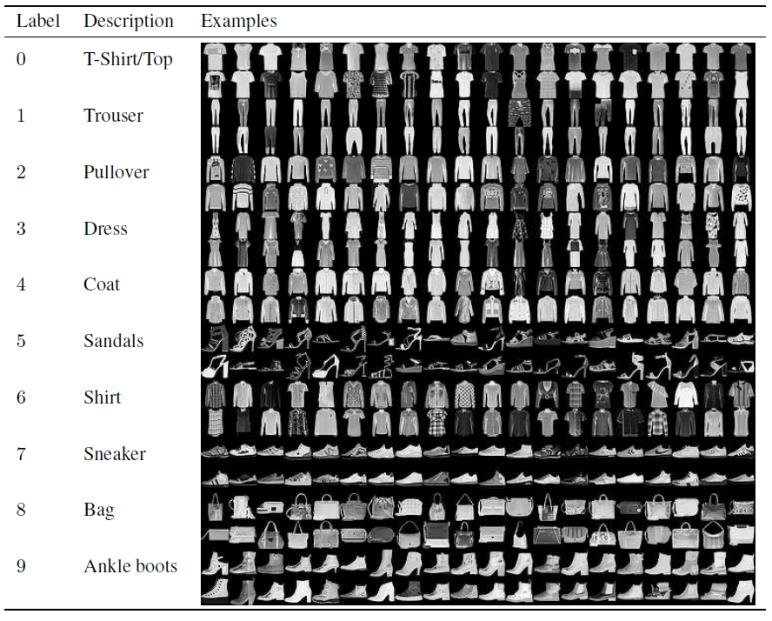

In [1]:
from IPython import display
display.Image(r'FashionMnist.png')

### Könyvtárak importálása

In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

from keras.callbacks import TensorBoard
%load_ext tensorboard
import tensorflow as tf
from tensorboard.plugins import projector
from tensorboard.plugins.hparams import api as hp

### Fashion MNIST Dataset előkészítése

In [3]:
# adatok beolvasása

train = pd.read_csv(r'datasetdir/fashion-mnist_train.csv')
test = pd.read_csv(r'datasetdir/fashion-mnist_test.csv')

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# átalakítás float32-be

train = np.array(train, dtype='float32')
test = np.array(test, dtype='float32')

In [6]:
# pixelek-labelek szétválasztása

X_train = train[:, 1:] / 255
y_train = train[:, 0]

X_test = test[:, 1:] / 255
y_test = test[:, 0]

In [7]:
# train szétválasztása train-re és validation-re

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
# képek átméretezése sorvektorból 28x28x1-re

im_dim = (28, 28)
im_shape = (*im_dim, 1)

X_train = X_train.reshape(X_train.shape[0], *im_shape)
X_val = X_val.reshape(X_val.shape[0], *im_shape)
X_test = X_test.reshape(X_test.shape[0], *im_shape)

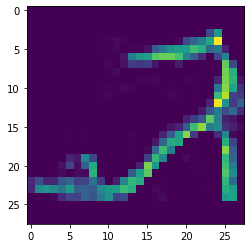

In [9]:
# 1. kép X_train-ben

im = X_train[0]

plt.imshow(im)

## A tesztháló programozása

In [10]:
# tensorboard meghatározása

tensorboard = TensorBoard(
    log_dir=r'logs/{}'.format('tesztmodell'),
    write_graph=True,
    write_grads=True,
    histogram_freq=1,
    write_images=True
)


In [11]:
# modell felépítése

def create_model():
    model = Sequential([
        Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=im_shape),
        MaxPooling2D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

In [12]:
# modell tanítása

def train_model_test():
    
    batch_size = 256
    lr = 0.001
    epochs = 30

    global model_test
    model_test = create_model()
    
    model_test.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=lr),
    metrics=['accuracy']
    )
    
    model_test.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[tensorboard]
    )
train_model_test()

Epoch 1/30
188/188 [==============================] - 21s 108ms/step - loss: 1.0413 - accuracy: 0.6408 - val_loss: 0.4619 - val_accuracy: 0.8332
Epoch 2/30
188/188 [==============================] - 20s 104ms/step - loss: 0.4391 - accuracy: 0.8448 - val_loss: 0.3771 - val_accuracy: 0.8661
Epoch 3/30
188/188 [==============================] - 19s 103ms/step - loss: 0.3695 - accuracy: 0.8699 - val_loss: 0.3503 - val_accuracy: 0.8761
Epoch 4/30
188/188 [==============================] - 19s 101ms/step - loss: 0.3388 - accuracy: 0.8815 - val_loss: 0.3451 - val_accuracy: 0.8758
Epoch 5/30
188/188 [==============================] - 18s 97ms/step - loss: 0.3233 - accuracy: 0.8867 - val_loss: 0.3164 - val_accuracy: 0.8876
Epoch 6/30
188/188 [==============================] - 18s 96ms/step - loss: 0.3017 - accuracy: 0.8942 - val_loss: 0.3092 - val_accuracy: 0.8892
Epoch 7/30
188/188 [==============================] - 18s 96ms/step - loss: 0.2847 - accuracy: 0.8975 - val_loss: 0.3009 - val_accur

### A modell értékelése

In [13]:
score = model_test.evaluate(X_test, y_test,  verbose=0)

In [14]:
print('loss: {:.4f}\nscore: {:.4f}'.format(score[0], score[1]))

loss: 0.2460
score: 0.9194


In [26]:
%tensorboard --logdir logs/tesztmodell --host localhost --port 6006

Reusing TensorBoard on port 6006 (pid 5448), started 2:07:54 ago. (Use '!kill 5448' to kill it.)

## Hiperparaméter hangolás

In [16]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.001, 0.0001]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_LEARNING_RATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [17]:
def train_test_model(hparams): 
    modelhp = Sequential([
        Conv2D(filters=hparams[HP_NUM_UNITS], kernel_size=3, activation='relu', input_shape=im_shape),
        MaxPooling2D(pool_size=2),
        Dropout(hparams[HP_DROPOUT]),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(10, activation='softmax')
    ])
    modelhp.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(lr=hparams[HP_LEARNING_RATE]),
        metrics=['accuracy']  
    )
    modelhp.fit(
        X_train,
        y_train,
        batch_size=256,
        epochs=15,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[
            TensorBoard('logs'),
            hp.KerasCallback('logs', hparams)
        ]
    )
    _, accuracy = modelhp.evaluate(X_test, y_test)
    return accuracy

In [18]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [19]:
session_num = 1

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for learning_rate in HP_LEARNING_RATE.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_LEARNING_RATE: learning_rate
            }
            run_name = "run-{}".format(session_num)
            print('---{}'.format(run_name))
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

---run-1
{'num_units': 32, 'dropout': 0.1, 'learning_rate': 0.0001}
Epoch 1/15
188/188 [==============================] - 20s 103ms/step - loss: 1.9716 - accuracy: 0.3671 - val_loss: 1.1109 - val_accuracy: 0.6909
Epoch 2/15
188/188 [==============================] - 19s 100ms/step - loss: 0.9672 - accuracy: 0.7271 - val_loss: 0.7108 - val_accuracy: 0.7799
Epoch 3/15
188/188 [==============================] - 19s 99ms/step - loss: 0.6772 - accuracy: 0.7891 - val_loss: 0.5861 - val_accuracy: 0.8095
Epoch 4/15
188/188 [==============================] - 19s 99ms/step - loss: 0.5741 - accuracy: 0.8141 - val_loss: 0.5261 - val_accuracy: 0.8218
Epoch 5/15
188/188 [==============================] - 19s 99ms/step - loss: 0.5207 - accuracy: 0.8284 - val_loss: 0.4876 - val_accuracy: 0.8346
Epoch 6/15
188/188 [==============================] - 19s 99ms/step - loss: 0.4842 - accuracy: 0.8395 - val_loss: 0.4614 - val_accuracy: 0.8407
Epoch 7/15
188/188 [==============================] - 19s 99ms/ste

188/188 [==============================] - 19s 101ms/step - loss: 0.2740 - accuracy: 0.8999 - val_loss: 0.2828 - val_accuracy: 0.8998
Epoch 9/15
188/188 [==============================] - 18s 98ms/step - loss: 0.2660 - accuracy: 0.9046 - val_loss: 0.2826 - val_accuracy: 0.9000
Epoch 10/15
188/188 [==============================] - 19s 98ms/step - loss: 0.2579 - accuracy: 0.9080 - val_loss: 0.2889 - val_accuracy: 0.8972
Epoch 11/15
188/188 [==============================] - 18s 97ms/step - loss: 0.2516 - accuracy: 0.9114 - val_loss: 0.2855 - val_accuracy: 0.8999
Epoch 12/15
188/188 [==============================] - 18s 98ms/step - loss: 0.2417 - accuracy: 0.9123 - val_loss: 0.2689 - val_accuracy: 0.9054
Epoch 13/15
188/188 [==============================] - 18s 97ms/step - loss: 0.2381 - accuracy: 0.9150 - val_loss: 0.2674 - val_accuracy: 0.9065
Epoch 14/15
188/188 [==============================] - 18s 97ms/step - loss: 0.2288 - accuracy: 0.9160 - val_loss: 0.2600 - val_accuracy: 0.90

313/313 [==============================] - 2s 6ms/step - loss: 0.3545 - accuracy: 0.8789
---run-8
{'num_units': 64, 'dropout': 0.2, 'learning_rate': 0.001}
Epoch 1/15
188/188 [==============================] - 36s 191ms/step - loss: 1.0485 - accuracy: 0.6408 - val_loss: 0.4508 - val_accuracy: 0.8367
Epoch 2/15
188/188 [==============================] - 35s 185ms/step - loss: 0.4363 - accuracy: 0.8444 - val_loss: 0.3893 - val_accuracy: 0.8614
Epoch 3/15
188/188 [==============================] - 35s 187ms/step - loss: 0.3689 - accuracy: 0.8716 - val_loss: 0.3427 - val_accuracy: 0.8767
Epoch 4/15
188/188 [==============================] - 35s 187ms/step - loss: 0.3311 - accuracy: 0.8825 - val_loss: 0.3181 - val_accuracy: 0.8883
Epoch 5/15
188/188 [==============================] - 35s 187ms/step - loss: 0.3065 - accuracy: 0.8926 - val_loss: 0.2960 - val_accuracy: 0.8956
Epoch 6/15
188/188 [==============================] - 35s 188ms/step - loss: 0.2866 - accuracy: 0.8985 - val_loss: 0.29

188/188 [==============================] - 65s 347ms/step - loss: 0.3967 - accuracy: 0.8627 - val_loss: 0.3942 - val_accuracy: 0.8662
Epoch 8/15
188/188 [==============================] - 64s 342ms/step - loss: 0.3859 - accuracy: 0.8666 - val_loss: 0.3797 - val_accuracy: 0.8683
Epoch 9/15
188/188 [==============================] - 64s 342ms/step - loss: 0.3697 - accuracy: 0.8730 - val_loss: 0.3701 - val_accuracy: 0.8725
Epoch 10/15
188/188 [==============================] - 64s 340ms/step - loss: 0.3628 - accuracy: 0.8753 - val_loss: 0.3669 - val_accuracy: 0.8719
Epoch 11/15
188/188 [==============================] - 64s 340ms/step - loss: 0.3543 - accuracy: 0.8783 - val_loss: 0.3595 - val_accuracy: 0.8747
Epoch 12/15
188/188 [==============================] - 64s 341ms/step - loss: 0.3431 - accuracy: 0.8819 - val_loss: 0.3502 - val_accuracy: 0.8780
Epoch 13/15
188/188 [==============================] - 64s 341ms/step - loss: 0.3382 - accuracy: 0.8851 - val_loss: 0.3435 - val_accuracy:

In [25]:
%tensorboard --logdir logs/hparam_tuning --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 3556), started 0:01:11 ago. (Use '!kill 3556' to kill it.)

## A végleges modell az új hiperparaméterekkel

In [30]:
modelv2 = Sequential([
        Conv2D(filters=128, kernel_size=3, activation='relu', input_shape=im_shape),
        MaxPooling2D(pool_size=2),
        Dropout(0.1),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(10, activation='softmax')
])

modelv2.compile(
loss='sparse_categorical_crossentropy',
optimizer=Adam(lr=0.001),
metrics=['accuracy']
)

modelv2.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=15,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/15
188/188 [==============================] - 66s 349ms/step - loss: 0.9511 - accuracy: 0.6738 - val_loss: 0.4375 - val_accuracy: 0.8418
Epoch 2/15
188/188 [==============================] - 65s 344ms/step - loss: 0.3864 - accuracy: 0.8674 - val_loss: 0.3346 - val_accuracy: 0.8838
Epoch 3/15
188/188 [==============================] - 65s 346ms/step - loss: 0.3318 - accuracy: 0.8846 - val_loss: 0.3139 - val_accuracy: 0.8902
Epoch 4/15
188/188 [==============================] - 65s 345ms/step - loss: 0.2959 - accuracy: 0.8957 - val_loss: 0.2920 - val_accuracy: 0.8985
Epoch 5/15
188/188 [==============================] - 65s 346ms/step - loss: 0.2728 - accuracy: 0.9037 - val_loss: 0.2891 - val_accuracy: 0.8995
Epoch 6/15
188/188 [==============================] - 65s 344ms/step - loss: 0.2500 - accuracy: 0.9138 - val_loss: 0.2899 - val_accuracy: 0.8953
Epoch 7/15
188/188 [==============================] - 64s 343ms/step - loss: 0.2326 - accuracy: 0.9174 - val_loss: 0.2746 - val_ac

In [31]:
scorev2 = modelv2.evaluate(X_test, y_test,  verbose=0)

In [32]:
print('loss: {:.4f}\nscore: {:.4f}'.format(scorev2[0], scorev2[1]))

loss: 0.2544
score: 0.9172


## A modell tesztelése

### A tesztadatokon

In [33]:
# index-label szótár

clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

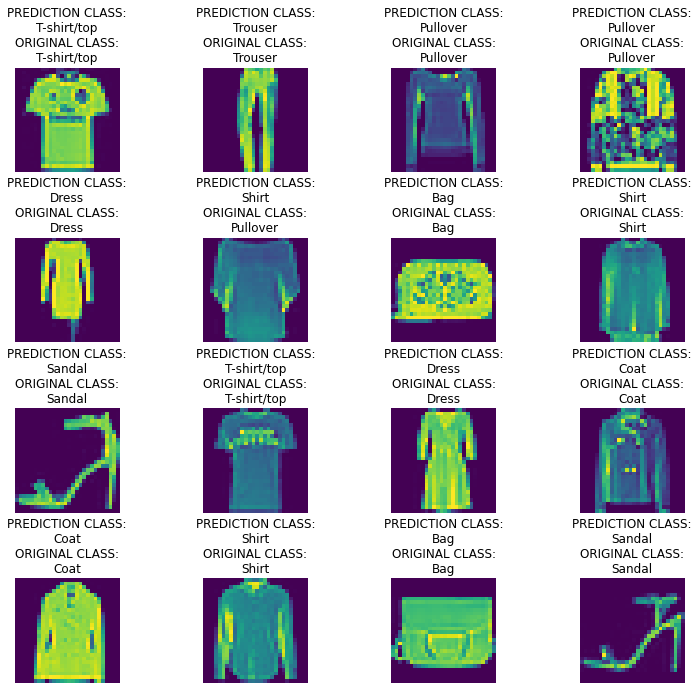

In [34]:
predicted_classes = np.argmax(modelv2.predict(X_test), axis=-1)

row, col = 4, 4
fig, axes = plt.subplots(row, col, figsize=(12,12))
axes = axes.ravel()

for i in range(row*col):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f'PREDICTION CLASS:\n{clothing[predicted_classes[i]]}\nORIGINAL CLASS:\n{clothing[y_test[i]]}')
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.8)

### Saját képeken

In [35]:
# 1. kép

display.Image(r'pic1.png')

In [36]:
pic1 = cv2.imread('pic1.png',0)
pic1 = pic1 / 255
pic1 = pic1.reshape((1,28,28,1))

modelv2.predict(pic1)

array([[6.4590961e-01, 2.5183122e-09, 3.1539337e-05, 1.1577333e-06,
        9.5848125e-05, 2.0161355e-09, 3.5388353e-01, 3.8364554e-08,
        7.8332800e-05, 7.5994698e-14]], dtype=float32)

In [37]:
clothing[np.argmax(modelv2.predict(pic1))]

'T-shirt/top'

<BarContainer object of 10 artists>

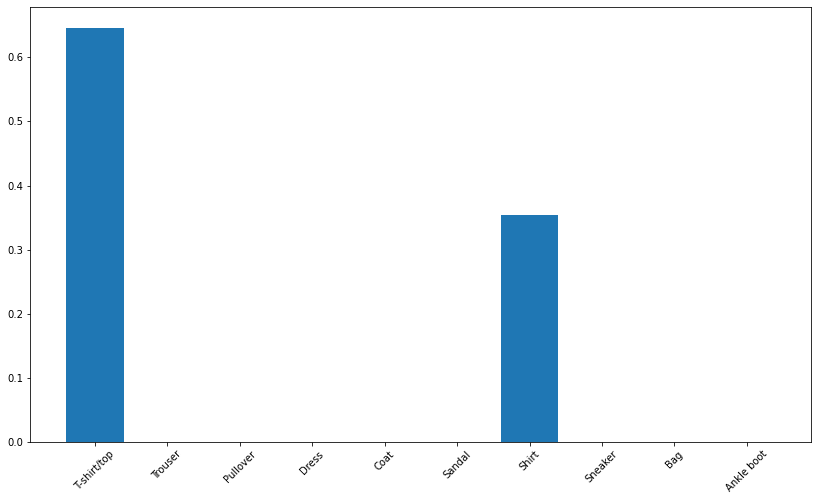

In [38]:
plt.figure(figsize=(14,8))
plt.xticks(rotation = 45)
plt.bar(x=clothing.values(), height=modelv2.predict(pic1)[0])

In [39]:
# 2. kép
display.Image(r'pic2.png')

In [41]:
pic2 = cv2.imread('pic2.png',0)
pic2 = pic2 / 255
pic2 = pic2.reshape((1,28,28,1))

modelv2.predict(pic2)

array([[9.0189232e-08, 1.6317239e-11, 5.8242398e-09, 1.0699817e-08,
        1.0047873e-07, 9.9998248e-01, 1.4818612e-11, 1.2991782e-11,
        1.7259692e-05, 1.2068921e-12]], dtype=float32)

In [42]:
clothing[np.argmax(modelv2.predict(pic2))]

'Sandal'

<BarContainer object of 10 artists>

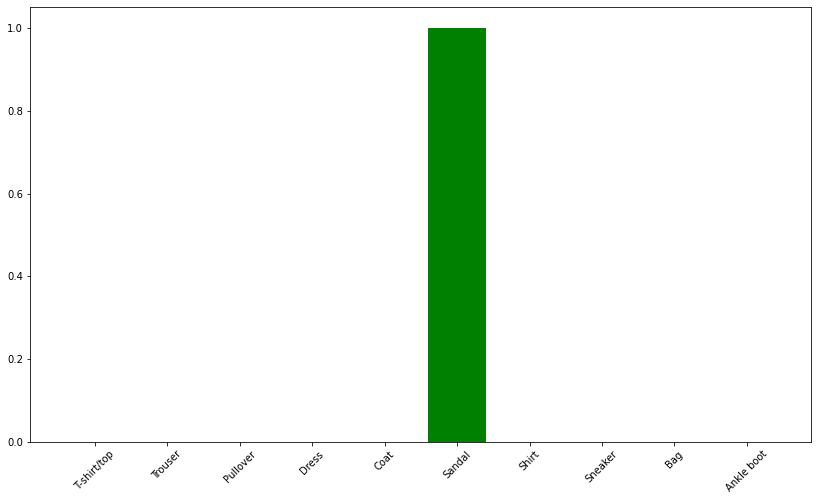

In [43]:
plt.figure(figsize=(14,8))
plt.xticks(rotation = 45)
plt.bar(x=clothing.values(), height=modelv2.predict(pic2)[0], color='g')